In [187]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
import dtreeviz

from tqdm import tqdm
import warnings
from pprint import pprint

In [188]:
data = pd.read_csv("./data/augmented_data.csv")

In [189]:
data.nunique()

period                     5
minute                   139
possession               290
duration               77925
season_id                 41
match_id                3312
timestamp              82726
team                     288
play_pattern               9
position                  25
location_x               635
location_x_distance      635
location_y               701
location_y_distance      471
technique                  7
body_part                  4
type                       5
is_penalty                 2
first_time                 2
open_goal                  2
one_on_one                 2
aerial_won                 2
follows_dribble            2
under_pressure             2
pass_duration          11897
pass_angle             10504
pass_type                  8
pass_height                4
pass_length             9918
num_passes                13
defenders_3m_radius       10
defenders_triangle        13
goalkeeper_x             258
goalkeeper_y             355
distance_to_go

In [190]:
# Use mutual_info classification to check which features yield the most information about the target variable
data_copy = data.copy()
X = data_copy.drop(["statsbomb_xg", "is_goal", "end_location_x", "end_location_y", "location_x", "location_y", "play_pattern", "technique", "position", "body_part", "type", "pass_type", "pass_height", "season_id", "match_id", "timestamp", "team"], axis=1)
mutual_info = mutual_info_classif(X, data["is_goal"])
mutual_info = pd.Series(mutual_info)
mutual_info.index = X.columns
mutual_info.sort_values(ascending=False)

distance_to_goalie     0.057840
defenders_triangle     0.038815
location_x_distance    0.034611
goalkeeper_x           0.028519
defenders_3m_radius    0.023623
location_y_distance    0.022648
duration               0.021875
goalkeeper_y           0.020764
is_penalty             0.015662
shot_angle             0.013443
open_goal              0.011991
pass_duration          0.011194
pass_length            0.010963
period                 0.008833
good_foot              0.006828
num_passes             0.006703
one_on_one             0.005221
first_time             0.003411
pass_angle             0.003209
under_pressure         0.002793
minute                 0.002707
game_state             0.002686
was_leading            0.002119
shots_so_far           0.002058
aerial_won             0.001031
xg_so_far              0.000898
possession             0.000688
follows_dribble        0.000000
dtype: float64

In [191]:
# drop redundant features
data.drop(["location_x", "location_y", "game_state"], axis=1, inplace=True)
# drop features that leak target information
data.drop(["shot_angle", "duration", "season_id", "match_id", "timestamp", "team"], axis=1, inplace=True)
# drop low information features
data.drop(["aerial_won", "follows_dribble", "possession", "minute", "period", "num_passes", "pass_duration", "pass_height", "pass_type", "pass_angle", "type", "shots_so_far", "xg_so_far"], axis=1, inplace=True)
# "position", "body_part", "type", "pass_height", "pass_type"

In [192]:
# one-hot encode the categorical data
encoded_data = data
for column_name in ["play_pattern", "technique", "position", "body_part"]:
    one_hot_encoded = pd.get_dummies(encoded_data[column_name], prefix=column_name)
    encoded_data = encoded_data.drop(column_name, axis=1)
    encoded_data = pd.concat([encoded_data, one_hot_encoded], axis=1)
data = encoded_data

In [193]:
data.nunique()

location_x_distance           635
location_y_distance           471
is_penalty                      2
first_time                      2
open_goal                       2
                             ... 
position_Secondary Striker      2
body_part_Head                  2
body_part_Left Foot             2
body_part_Other                 2
body_part_Right Foot            2
Length: 64, dtype: int64

In [194]:
data = data.dropna()
data.replace([np.inf, -np.inf], 0, inplace=True)

In [195]:
y1 = data["statsbomb_xg"]
y2 = data["is_goal"]
X = data.drop(["statsbomb_xg", "is_goal", "end_location_x", "end_location_y"], axis=1)

In [196]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83929 entries, 0 to 83928
Data columns (total 60 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   location_x_distance                 83929 non-null  float64
 1   location_y_distance                 83929 non-null  float64
 2   is_penalty                          83929 non-null  bool   
 3   first_time                          83929 non-null  bool   
 4   open_goal                           83929 non-null  bool   
 5   one_on_one                          83929 non-null  bool   
 6   under_pressure                      83929 non-null  bool   
 7   pass_length                         83929 non-null  float64
 8   defenders_3m_radius                 83929 non-null  int64  
 9   defenders_triangle                  83929 non-null  int64  
 10  goalkeeper_x                        83929 non-null  float64
 11  goalkeeper_y                        83929

In [197]:
def preprocess_continuous(X, y):

    scaler = StandardScaler().fit(X)
    X = scaler.transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=20)

    return X_train, X_test, y_train, y_test

In [198]:
def preprocess_classifier(X, y):

    scaler = StandardScaler().fit(X)
    X = scaler.transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=20)

    X_train, y_train = SMOTE(sampling_strategy=0.32).fit_resample(X_train, y_train)

    return X_train, X_test, y_train, y_test

In [199]:
def calculate_errors(results_test, results_pred, name):
    mae = mean_absolute_error(results_test, results_pred)
    rmse = root_mean_squared_error(results_test, results_pred)
    r2 = r2_score(results_test, results_pred)
    print(f"\n{name}")
    print("Mean Absolute Error:", mae)
    print("Root Mean Squared Error:", rmse)
    print("R-squared (R2 Score):", r2)

In [200]:
def calculate_stats(results_test, results_pred, name):
    cm = confusion_matrix(results_test, results_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not a goal", "Goal"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix ({name})')
    plt.show()

    print(f"\n{name}")
    accuracy = accuracy_score(results_test, results_pred)
    precision = precision_score(results_test, results_pred)
    recall = recall_score(results_test, results_pred)
    f1 = f1_score(results_test, results_pred)
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1:", f1)

In [201]:
def linear_regression():
    linear_r = LinearRegression()
    linear_r.fit(X_train, y_train)
    y_pred = linear_r.predict(X_test)

    calculate_errors(y_test, y_pred, "Linear Regression")

    return y_pred

In [202]:
def logistic_regression():
    logistic_r = LogisticRegression()
    logistic_r.fit(X_train, y_train)
    y_pred = logistic_r.predict(X_test)

    calculate_stats(y_test, y_pred, "Logistic Regression")

    return logistic_r.predict_proba(X_test)

In [203]:
def decision_tree():
    dt = DecisionTreeClassifier(criterion="gini", max_depth=12, max_leaf_nodes=50, min_samples_split=100)
    dt.fit(X_train, y_train)
    y_pred = dt.predict(X_test)

    calculate_stats(y_test, y_pred, "Decision Tree")

    viz_model = dtreeviz.model(dt,
                           X_train=X_train, y_train=y_train,
                           feature_names=X.columns, target_name="is_goal", class_names=["Not a goal", "Goal"])

    return dt.predict_proba(X_test), viz_model

In [204]:
def gradient_boosted_tree():
    gbt = GradientBoostingClassifier(learning_rate=0.10, max_depth=12, min_samples_split=100, n_estimators=250, max_features=None)
    gbt.fit(X_train, y_train)
    y_pred = gbt.predict(X_test)

    calculate_stats(y_test, y_pred, "Gradient Boosted Tree")

    return gbt.predict_proba(X_test)

In [205]:
X_train, X_test, y_train, y_test = preprocess_continuous(X, y1)
lr_xg = linear_regression()


Linear Regression
Mean Absolute Error: 0.04945287667322289
Root Mean Squared Error: 0.07675509640188097
R-squared (R2 Score): 0.7421864590882884


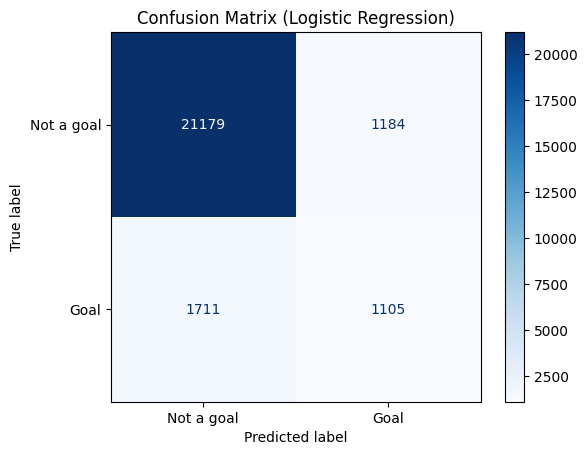


Logistic Regression
Accuracy: 0.8850232336470869
Precision: 0.48274355613805153
Recall: 0.3924005681818182
F1: 0.43290891283055827


In [206]:
X_train, X_test, y_train, y_test = preprocess_classifier(X, y2)
lor_xg = logistic_regression()

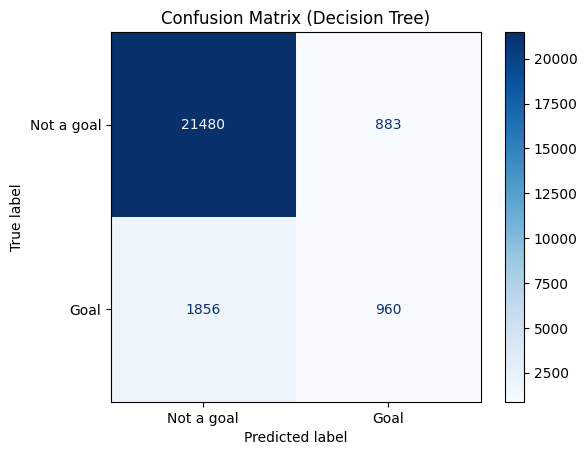


Decision Tree
Accuracy: 0.891218872870249
Precision: 0.5208898534997287
Recall: 0.3409090909090909
F1: 0.412105602060528


In [207]:
dt_xg, viz = decision_tree()

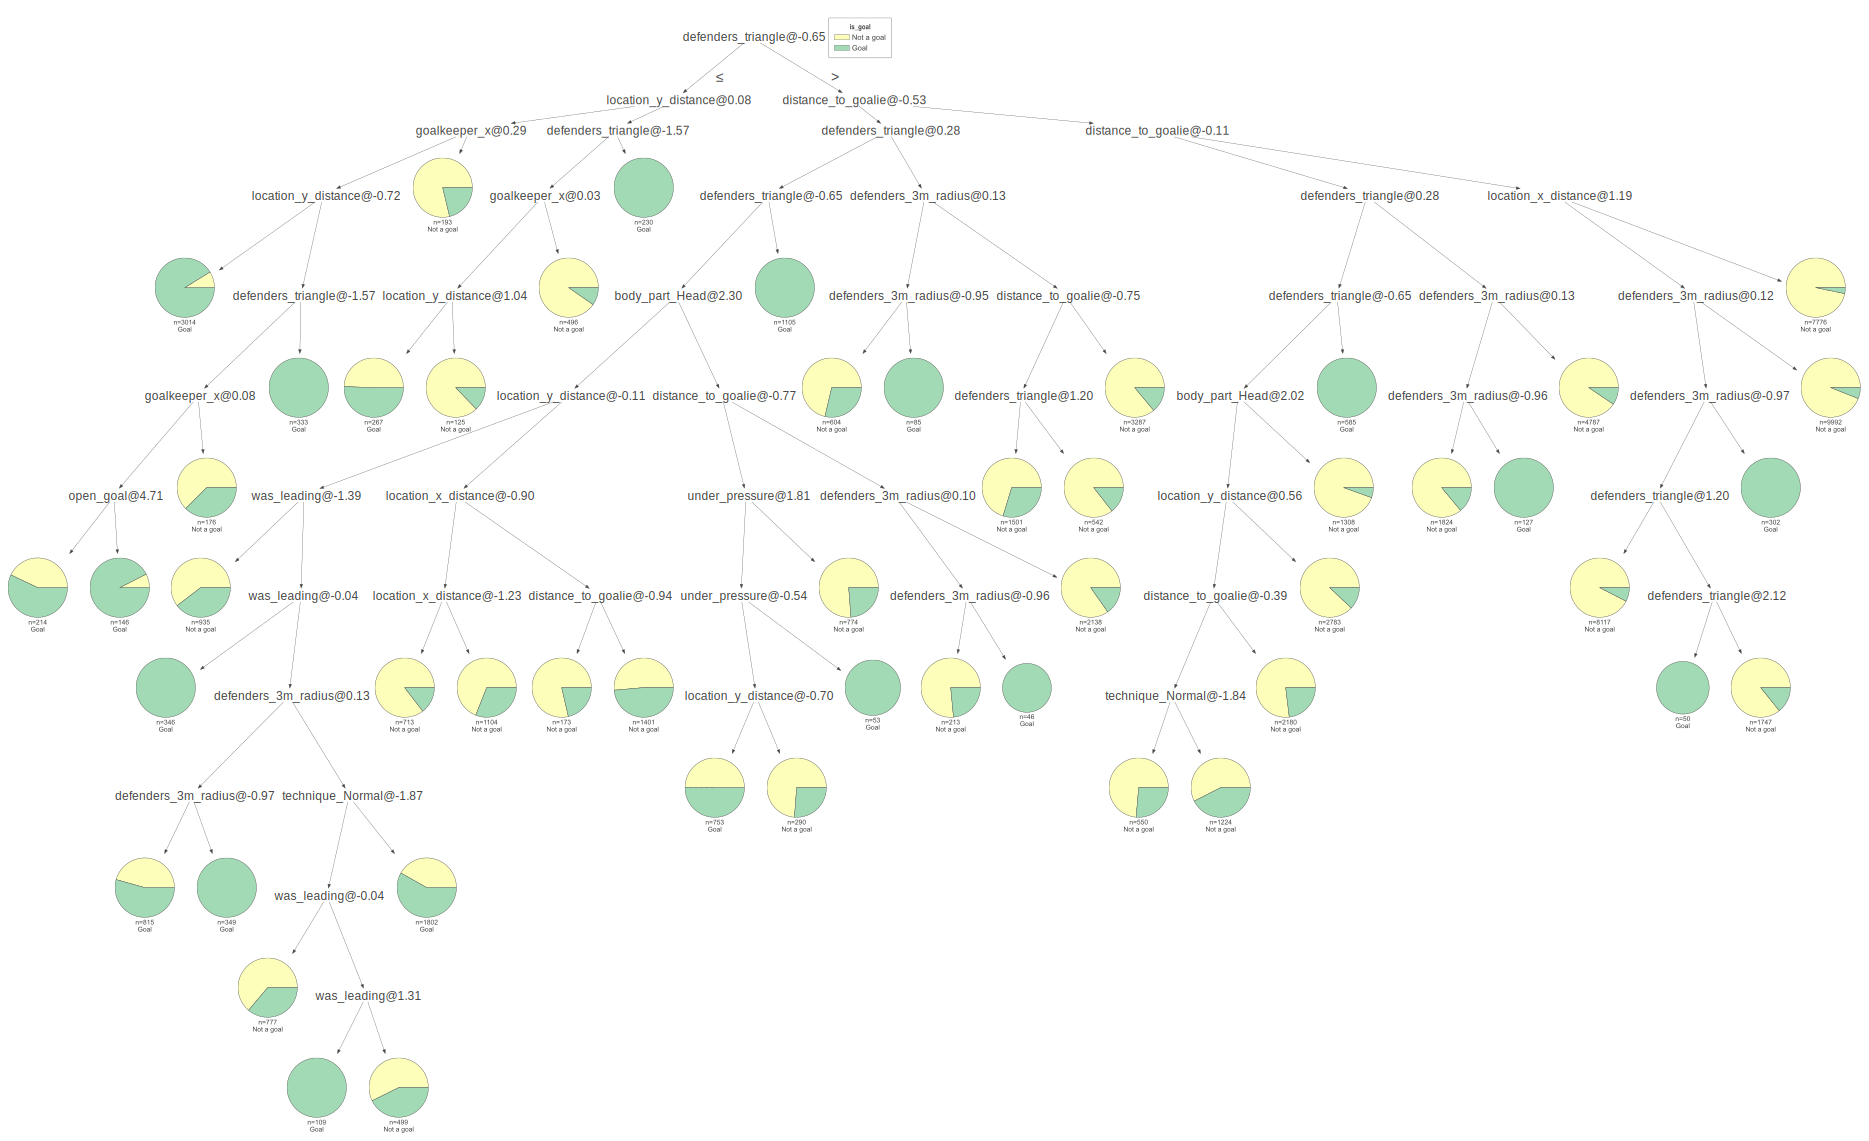

In [208]:
viz.view(fancy=False)

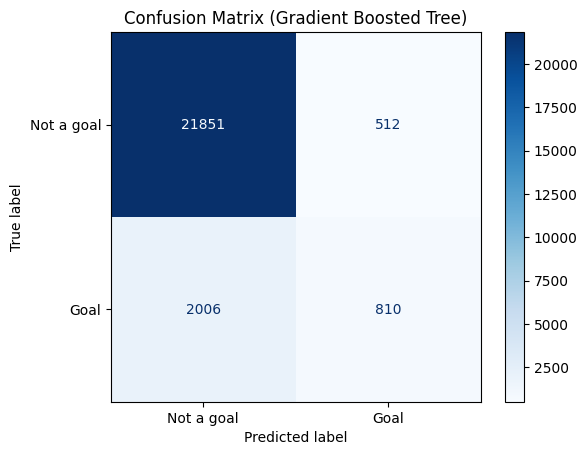


Gradient Boosted Tree
Accuracy: 0.8999960284363954
Precision: 0.6127080181543116
Recall: 0.28764204545454547
F1: 0.3914934751087482


In [209]:
gbt_xg = gradient_boosted_tree()

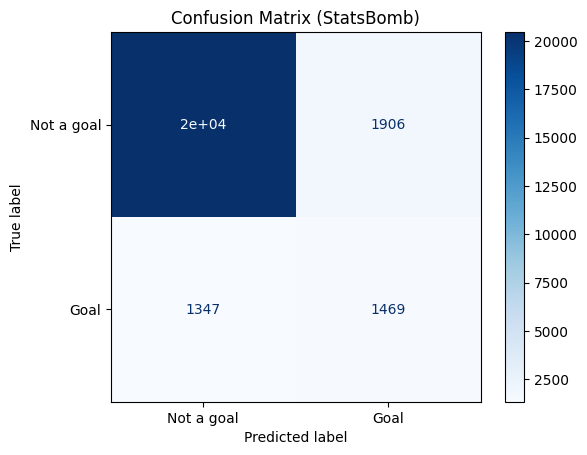


StatsBomb
Accuracy: 0.8708050359426506
Precision: 0.43525925925925923
Recall: 0.5216619318181818
F1: 0.4745598449361977


In [210]:
# empirically, the statsbomb predictions maximise f1 score at threshold=0.15, precision at threshold=1, recall at threshold=0, and accuracy at threshold=20
_, X_temp, _, sb_xg = preprocess_continuous(X, y1)
sb_pred = sb_xg.apply(lambda x: math.ceil(x-0.20))
calculate_stats(y_test, sb_pred, "StatsBomb")

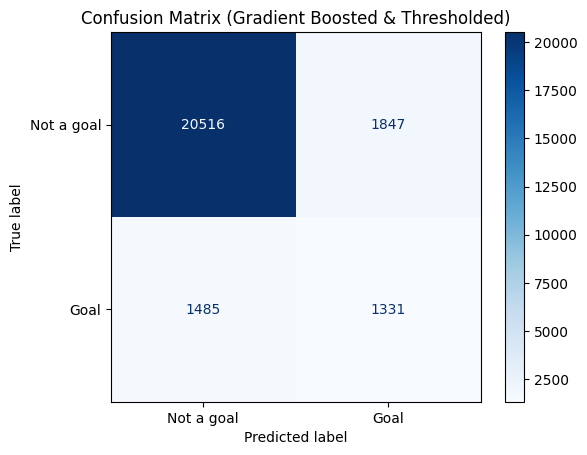


Gradient Boosted & Thresholded
Accuracy: 0.8676675006950236
Precision: 0.4188168659534298
Recall: 0.47265625
F1: 0.44411077744411076


In [211]:
# empirically, the statsbomb predictions maximise f1 score at threshold=0.15, precision at threshold=1, recall at threshold=0, and accuracy at threshold=20
gbt_pred = [math.ceil(x[1]-0.24) for x in gbt_xg]
calculate_stats(y_test, gbt_pred, "Gradient Boosted & Thresholded")

In [212]:
df = pd.DataFrame({"lr_xg": lr_xg, "lor_xg": [x[1] for x in lor_xg], "dt_xg": [x[1] for x in dt_xg], "gbt_xg": [x[1] for x in gbt_xg], "sxg": sb_xg})
pprint(pd.DataFrame(np.corrcoef(np.asarray(df["lr_xg"]), np.asarray(df["sxg"]))))
pprint(pd.DataFrame(np.corrcoef(np.asarray(df["lor_xg"]), np.asarray(df["sxg"]))))
pprint(pd.DataFrame(np.corrcoef(np.asarray(df["dt_xg"]), np.asarray(df["sxg"]))))
pprint(pd.DataFrame(np.corrcoef(np.asarray(df["gbt_xg"]), np.asarray(df["sxg"]))))

         0        1
0  1.00000  0.86155
1  0.86155  1.00000
          0         1
0  1.000000  0.857492
1  0.857492  1.000000
          0         1
0  1.000000  0.853541
1  0.853541  1.000000
          0         1
0  1.000000  0.849486
1  0.849486  1.000000


In [213]:
diff = gbt_pred - y_test
data_copy.iloc[diff[diff == -1].index].sort_values(by=["statsbomb_xg"])

,period,minute,possession,duration,season_id,match_id,timestamp,team,play_pattern,position,...,statsbomb_xg,end_location_x,end_location_y,is_goal,shot_angle,good_foot,shots_so_far,xg_so_far,game_state,was_leading
81570,1.0,9.0,19.0,2.107967,2015/2016,3901235.0,00:09:53.043,Lyon,From Corner,Right Wing,...,0.000180,120.0,39.4,True,-1.560772,True,1,0.035773,-1.0,-1
19434,2.0,57.0,147.0,1.692302,2019/2020,2275036.0,00:12:55.614,Everton LFC,From Corner,Left Wing,...,0.000180,120.0,39.5,True,1.555334,True,2,0.377138,1.0,1
83046,1.0,31.0,55.0,1.424321,2023,3920399.0,00:31:49.211,Cape Verde Islands,From Free Kick,Center Forward,...,0.005564,120.0,41.8,True,-0.288918,False,8,0.496569,2.0,1
38905,1.0,19.0,39.0,1.989128,2021/2022,3813271.0,00:19:41.312,Kerala Blasters,Regular Play,Left Midfield,...,0.005734,120.0,43.4,True,0.666398,True,5,0.831732,1.0,1
21387,2.0,82.0,162.0,2.203068,2019/2020,2275150.0,00:37:35.289,West Ham United LFC,From Free Kick,Left Wing Back,...,0.005921,120.0,39.3,True,-0.942000,True,5,0.325982,-1.0,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37870,5.0,125.0,236.0,0.524014,2020,3795108.0,00:05:07.463,Spain,Other,Center Forward,...,0.783500,120.0,43.5,True,0.283794,False,9,3.080425,0.0,0
33012,1.0,48.0,88.0,0.354328,2020/2021,3773369.0,00:48:12.346,Huesca,Other,Left Center Forward,...,0.783500,120.0,42.3,True,0.189370,True,7,1.318064,-4.0,-1
22921,2.0,82.0,174.0,0.539718,2015/2016,3753978.0,00:37:53.965,Swansea City,Other,Left Attacking Midfield,...,0.783500,120.0,39.5,True,-0.058756,True,9,0.476477,-2.0,-1
64421,1.0,14.0,32.0,0.367564,2015/2016,3879812.0,00:14:05.535,Lazio,From Throw In,Center Forward,...,0.817662,120.0,37.7,True,0.982794,False,8,0.485214,1.0,1


In [214]:
diff_sb = sb_pred - y_test
data_copy.iloc[diff_sb[diff_sb == -1].index].sort_values(by=["statsbomb_xg"])

,period,minute,possession,duration,season_id,match_id,timestamp,team,play_pattern,position,...,statsbomb_xg,end_location_x,end_location_y,is_goal,shot_angle,good_foot,shots_so_far,xg_so_far,game_state,was_leading
9678,2.0,82.0,191.0,2.091759,2019,68357.0,00:37:50.104,Australia Women's,From Corner,Left Back,...,0.000180,120.0,38.4,True,-1.558631,True,18,3.469805,-4.0,-1
81570,1.0,9.0,19.0,2.107967,2015/2016,3901235.0,00:09:53.043,Lyon,From Corner,Right Wing,...,0.000180,120.0,39.4,True,-1.560772,True,1,0.035773,-1.0,-1
27627,1.0,1.0,6.0,2.124788,2015/2016,3754162.0,00:01:40.906,AFC Bournemouth,From Corner,Left Midfield,...,0.000180,120.0,43.4,True,1.575513,True,0,0.000000,0.0,0
19434,2.0,57.0,147.0,1.692302,2019/2020,2275036.0,00:12:55.614,Everton LFC,From Corner,Left Wing,...,0.000180,120.0,39.5,True,1.555334,True,2,0.377138,1.0,1
83046,1.0,31.0,55.0,1.424321,2023,3920399.0,00:31:49.211,Cape Verde Islands,From Free Kick,Center Forward,...,0.005564,120.0,41.8,True,-0.288918,False,8,0.496569,2.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55017,2.0,100.0,190.0,1.245307,2022,3857273.0,00:55:37.150,Iran,From Counter,Right Back,...,0.199331,120.0,40.6,True,-0.299885,False,20,1.254627,1.0,1
38169,2.0,91.0,182.0,0.546392,2021/2022,3802685.0,00:46:23.391,Paris Saint-Germain,From Free Kick,Right Center Midfield,...,0.199503,120.0,36.6,True,-0.527146,False,10,1.384874,-1.0,-1
53635,1.0,29.0,47.0,0.779014,2022/2023,3837706.0,00:29:07.499,Paris Saint-Germain,From Throw In,Left Attacking Midfield,...,0.199597,120.0,43.2,True,0.994135,False,7,0.818298,0.0,0
11034,1.0,30.0,76.0,0.904046,2008/2009,69185.0,00:30:01.508,Barcelona,Regular Play,Right Wing,...,0.199767,120.0,43.7,True,0.905507,False,9,1.528228,1.0,1


In [215]:
_, data_copy_test, _, gbt_xg_test = train_test_split(data_copy, y2, test_size=0.3, random_state=20)
diff_xg = [x[1] for x in gbt_xg] - sb_xg
data_copy_test["diff"] = diff_xg
data_copy_test["gbt_xg"] = [x[1] for x in gbt_xg]
data_copy_test["sb_xg"] = sb_xg
data_copy_test.sort_values(by=["diff"])

,period,minute,possession,duration,season_id,match_id,timestamp,team,play_pattern,position,...,is_goal,shot_angle,good_foot,shots_so_far,xg_so_far,game_state,was_leading,diff,gbt_xg,sb_xg
83597,1.0,36.0,57.0,0.174877,2023,3922240.0,00:36:45.900,Congo DR,From Throw In,Right Wing,...,True,-0.266252,False,20,7.752528,1.0,1,-0.802392,0.071867,0.874259
55988,5.0,123.0,252.0,0.380115,2022,3869685.0,00:03:29.289,France,Other,Right Defensive Midfield,...,False,-0.361531,True,2,1.567000,-2.0,-1,-0.758193,0.025307,0.783500
22921,2.0,82.0,174.0,0.539718,2015/2016,3753978.0,00:37:53.965,Swansea City,Other,Left Attacking Midfield,...,True,-0.058756,True,9,0.476477,-2.0,-1,-0.750742,0.032758,0.783500
10472,2.0,68.0,138.0,0.447000,2019,69163.0,00:23:27.055,Canada Women's,Other,Right Back,...,False,-0.255943,True,3,0.205541,-1.0,-1,-0.740250,0.043250,0.783500
82865,1.0,18.0,36.0,0.415941,2023,3920391.0,00:18:47.136,South Africa,Other,Right Midfield,...,False,-0.270513,False,4,0.248087,-1.0,-1,-0.740183,0.043317,0.783500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82168,1.0,29.0,63.0,0.546245,2015/2016,3901261.0,00:29:09.005,Paris Saint-Germain,Regular Play,Center Forward,...,False,0.486899,True,8,1.780175,2.0,1,0.707606,0.872784,0.165178
44286,2.0,89.0,197.0,2.733083,2015/2016,3825665.0,00:44:46.535,Athletic Club,From Throw In,Center Attacking Midfield,...,False,-0.066180,True,10,0.746557,-1.0,-1,0.736028,0.744178,0.008150
42066,2.0,60.0,128.0,1.635254,2015/2016,3825578.0,00:15:50.035,Eibar,From Corner,Center Attacking Midfield,...,True,-1.338692,False,2,0.323709,0.0,0,0.744853,0.819535,0.074682
19543,1.0,21.0,43.0,1.645438,2019/2020,2275042.0,00:21:06.051,Manchester City WFC,Regular Play,Left Defensive Midfield,...,False,0.717541,False,8,0.781985,2.0,1,0.834771,0.883700,0.048929


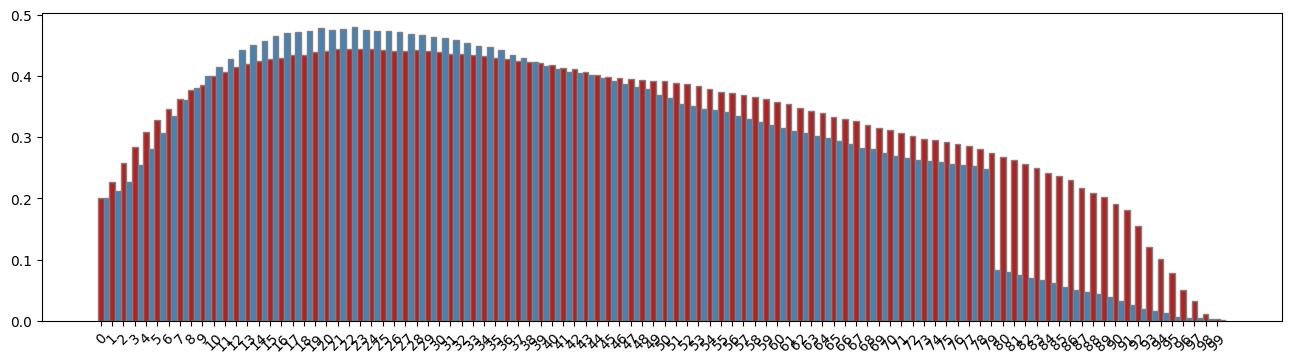

In [216]:
my_f1_scores = []
sb_f1_scores = []
for threshold in range(0, 100):
    gbt_pred = [math.ceil(x[1]-(threshold/100)) for x in gbt_xg]
    sb_pred = [math.ceil(x-(threshold/100)) for x in sb_xg]
    my_f1 = f1_score(y_test, gbt_pred)
    sb_f1 = f1_score(y_test, sb_pred)
    my_f1_scores.append(my_f1)
    sb_f1_scores.append(sb_f1)

barWidth = 0.5
r1 = np.arange(len(my_f1_scores))
r2 = [x + barWidth for x in r1]

plt.rcParams["font.size"] = 10
plt.rcParams["font.stretch"] = "semi-condensed"
plt.rcParams['grid.color'] = 'grey'

plt.figure(figsize=(16,4))
plt.bar(r1, pd.Series(my_f1_scores), color="firebrick", width=barWidth, edgecolor='grey', label='Our Prediction')
plt.bar(r2, pd.Series(sb_f1_scores), color="steelblue", width=barWidth, edgecolor='grey', label='SB Prediction')

plt.xticks(r1, [x for x in range(0, 100)], rotation=45)
plt.show()